![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-ocr-workshop/blob/master/tutorials/Certification_Trainings/1.3.Trasformer_based_Text_Recognition.ipynb)

## Blogposts and videos

- [Text Detection in Spark OCR](https://medium.com/spark-nlp/text-detection-in-spark-ocr-dcd8002bdc97)

- [Table Detection & Extraction in Spark OCR](https://medium.com/spark-nlp/table-detection-extraction-in-spark-ocr-50765c6cedc9)

- [Extract Tabular Data from PDF in Spark OCR](https://medium.com/spark-nlp/extract-tabular-data-from-pdf-in-spark-ocr-b02136bc0fcb)

- [Signature Detection in Spark OCR](https://medium.com/spark-nlp/signature-detection-in-spark-ocr-32f9e6f91e3c)

- [GPU image pre-processing in Spark OCR](https://medium.com/spark-nlp/gpu-image-pre-processing-in-spark-ocr-3-1-0-6fc27560a9bb)

- [How to Setup Spark OCR on UBUNTU - Video](https://www.youtube.com/watch?v=cmt4WIcL0nI)


**More examples here**

https://github.com/JohnSnowLabs/spark-ocr-workshop

In [2]:
import json, os
import sys

if 'google.colab' in sys.modules:
    from google.colab import files

    if 'spark_ocr.json' not in os.listdir():
      license_keys = files.upload()
      os.rename(list(license_keys.keys())[0], 'spark_ocr.json')

with open('spark_ocr.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [ ]:
# Installing pyspark and spark-nlp
%pip install --upgrade -q pyspark==3.0.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark OCR
#! pip uninstall spark-ocr -Y
%pip install spark-ocr==$OCR_VERSION\+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET --upgrade

<b><h1><font color='darkred'>!!! ATTENTION !!! </font><h1><b>

<b>After running previous cell, <font color='darkred'>RESTART the COLAB RUNTIME </font> and go ahead.<b>

In [1]:
import json, os

with open("spark_ocr.json", 'r') as f:
  license_keys = json.load(f)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [2]:
import pkg_resources

from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

from sparkocr import start
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import *
from sparkocr.metrics import score

In [3]:
# Start spark
spark = start(secret=SPARK_OCR_SECRET, nlp_version=PUBLIC_VERSION)

16:59:34, INFO SparkConf Configured, Starting to listen on port: 52102
16:59:34, INFO 52102
16:59:35, INFO Adding jar from /Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkmonitor/listener_2.12.jar 


Spark version: 3.0.2
Spark NLP version: 3.4.4
Spark OCR version: 3.14.0



17:01:29, INFO Client Connected ('127.0.0.1', 52174)


## Read image


    Image #0:
    Origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 199 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


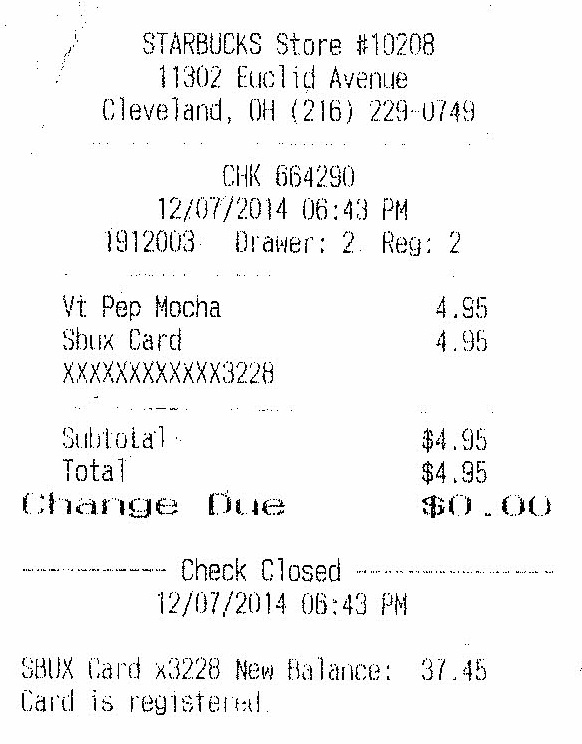

In [4]:
image_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/images/check.jpg')
image_example_df = spark.read.format("binaryFile").load(image_path)
image_df = BinaryToImage().transform(image_example_df).cache()

display_images(image_df)

In [5]:
binary_to_image = BinaryToImage() 
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

text_detector = ImageTextDetectorV2 \
    .pretrained("image_text_detector_v2", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("text_regions") \
    .setScoreThreshold(0.5) \
    .setTextThreshold(0.2) \
    .setSizeThreshold(10) \
    .setWithRefiner(True)

draw_regions = ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("text_regions") \
    .setOutputCol("image_with_regions") \
    .setRectColor(Color.green) \
    .setRotated(True)

pipeline = PipelineModel(stages=[
    binary_to_image,
    text_detector,
    draw_regions
])

image_text_detector_v2 download started this may take some time.
Approximate size to download 75.3 MB


## Run pipeline and show results


    Image #0:
    Origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 0 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


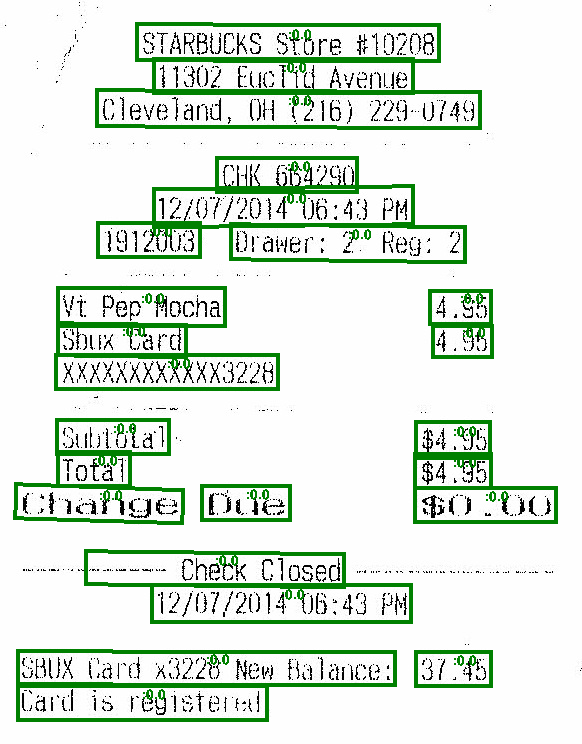

In [6]:
result = pipeline.transform(image_example_df)
display_images(result, "image_with_regions")

## Disable refiner and tune thresholds for detect each word separately


    Image #0:
    Origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 0 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


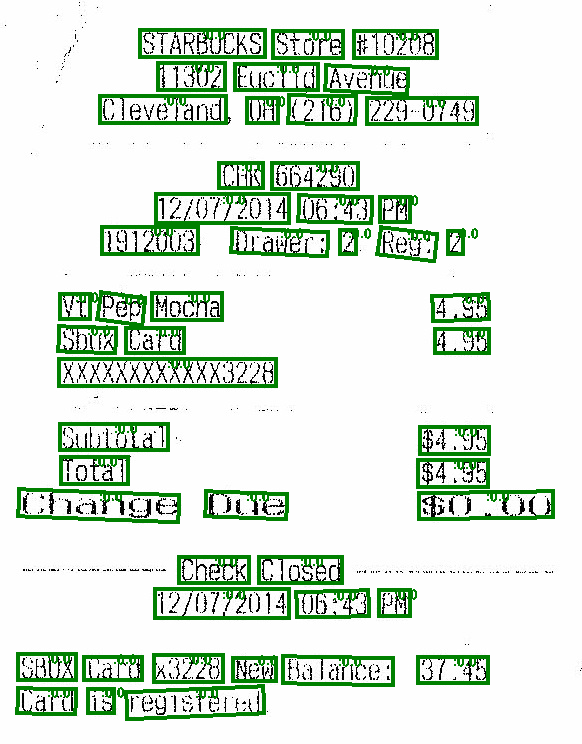

In [9]:
pipeline.stages[1].setWithRefiner(False)
pipeline.stages[1].setSizeThreshold(15)
pipeline.stages[1].setLinkThreshold(0.3)
pipeline.stages[1].setScoreThreshold(0.7)
pipeline.stages[1].setTextThreshold(0.4)
pipeline.stages[1].setMergeIntersects(True)

result = pipeline.transform(image_example_df)
display_images(result, "image_with_regions")

In [11]:
ocr = ImageToTextV2.pretrained("ocr_small_printed", "en", "clinical/ocr") \
    .setInputCols(["image", "text_regions"]) \
    .setOutputCol("text") \
    .setOutputFormat(OcrOutputFormat.TEXT) \
    .setLineTolerance(0) \
    .setGroupImages(False)

print(("").join([x.text for x in ocr.transform(result).select("text").collect()]))

ocr_small_printed download started this may take some time.
Approximate size to download 139.9 MB
STARBUCKS STORE #10208
11302 EUCLID AVENUE
CLEVELAND OH (216) 229-0749
CHK 664290
12/07/2014 06:43 PM
1912003 DRAMER: 2 REG: 2
VT PEP MOCHA 4.95
SBUX CARD 4.95
XXXXXXXXXXXX3228
SUBTOTAL $4.95
TOTAL $4.95
CHANGE DUE $0.00
CHECK CLOSED
12/07/2014 06:43 PM
SBUX CARD X3228 NEW BALANCE: 37.45
CARD IS REGISTERED


In [12]:
ocr_formatted = ImageToTextV2.pretrained("ocr_small_printed", "en", "clinical/ocr") \
    .setInputCols(["image", "text_regions"]) \
    .setOutputCol("text_formatted") \
    .setOutputFormat(OcrOutputFormat.FORMATTED_TEXT) \
    .setLineTolerance(0) \
    .setGroupImages(False) 

print(("").join([x.text_formatted for x in ocr_formatted.transform(result).select("text_formatted").collect()]))

ocr_small_printed download started this may take some time.
Approximate size to download 139.9 MB
          STARBUCKS  STORE #10208
            11302 EUCLID AVENUE
       CLEVELAND  OH  (216) 229-0749

                CHK 664290
           12/07/2014 06:43  PM
       1912003   DRAMER:  2  REG: 2

    VT PEP MOCHA                 4.95
    SBUX CARD                    4.95
    XXXXXXXXXXXX3228

    SUBTOTAL                    $4.95
    TOTAL                       $4.95
 CHANGE        DUE              $0.00

             CHECK CLOSED
           12/07/2014 06:43  PM

 SBUX CARD X3228 NEW BALANCE:   37.45
 CARD IS REGISTERED


### Define pipeline for recognize text and get results in HOCR format

In [13]:
binary_to_image = BinaryToImage() 
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

text_detector = ImageTextDetectorV2 \
    .pretrained("image_text_detector_v2", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("text_regions") \
    .setWithRefiner(False) \
    .setSizeThreshold(15) \
    .setLinkThreshold(0.3)

ocr = ImageToTextV2.pretrained("ocr_small_printed", "en", "clinical/ocr") \
    .setInputCols(["image", "text_regions"]) \
    .setOutputCol("hocr") \
    .setOutputFormat(OcrOutputFormat.HOCR) \
    .setGroupImages(False) 

tokenizer = HocrTokenizer() \
    .setInputCol("hocr") \
    .setOutputCol("token") \

draw_annotations = ImageDrawAnnotations() \
    .setInputCol("image") \
    .setInputChunksCol("token") \
    .setOutputCol("image_with_annotations") \
    .setFilledRect(False) \
    .setFontSize(14) \
    .setRectColor(Color.red)

hocr_pipeline = PipelineModel(stages=[
    binary_to_image,
    text_detector,
    ocr,
    tokenizer,
    draw_annotations
])

image_text_detector_v2 download started this may take some time.
Approximate size to download 75.3 MB
ocr_small_printed download started this may take some time.
Approximate size to download 139.9 MB



    Image #0:
    Origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 0 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


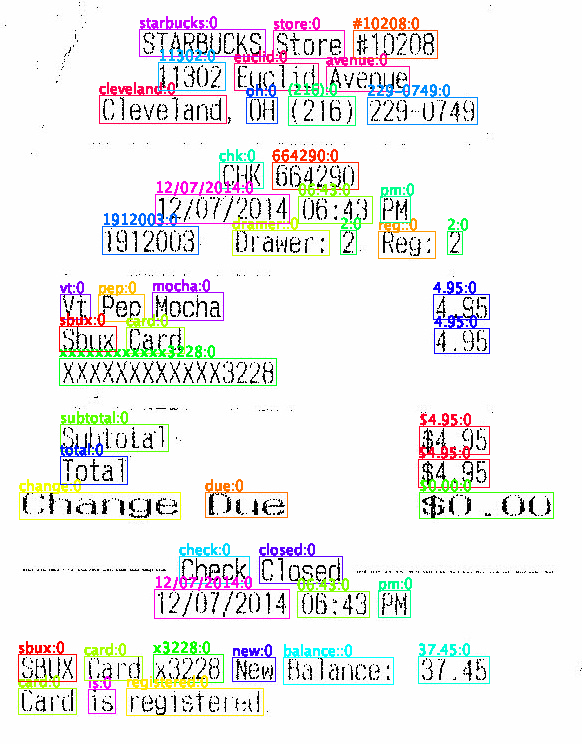

In [15]:
hocr_result = hocr_pipeline.transform(image_example_df).cache()
display_images(hocr_result, "image_with_annotations", width=1000)

In [18]:
print(hocr_result.select("hocr").collect()[0].hocr)

<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html xmlns="http://www.w3.org/1999/xhtml" xml:lang="en" lang="en">
  <head>
    <title></title>
    <meta http-equiv="Content-Type" content="text/html;charset=utf-8" />
    <meta name='ocr-system' content='Spark OCR' />
    <meta name='ocr-langs' content='en' />
    <meta name='ocr-number-of-pages' content='1' />
    <meta name='ocr-capabilities' content='ocr_page ocr_carea ocr_line ocrx_word ocrp_lang'/>
  </head>
  <body>
    <div class='ocr_page' lang='en' title='bbox 0 0 553 715'>
        <div class='ocr_carea' lang='en' title='bbox 18 29 553 715'>
            <span class='ocr_line' id='line_0' title='bbox 139 29 437 58; baseline 0 -5'>
                <span class='ocrx_word' id='word_0_0' title='bbox 139 29 265 56'>STARBUCKS</span>
                <span class='ocrx_word' id='word_0_1' title='bbox 273 30 344 58'>STORE</spa